In [1]:
'''Testing the Chopin repo for debugging'''

import warnings; warnings.simplefilter('ignore')  # hide warnings

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

np.random.seed(0)

from particles import distributions as dists
from particles import SMC,kalman
from particles.collectors import Moments
import seaborn as sb

prior_dict = {
              'rho': dists.Uniform(a=-1., b=1.),
              'sigmaX':dists.Gamma(2,2),
              'sigmaY':dists.Gamma(2,2)}
my_prior = dists.StructDist(prior_dict)

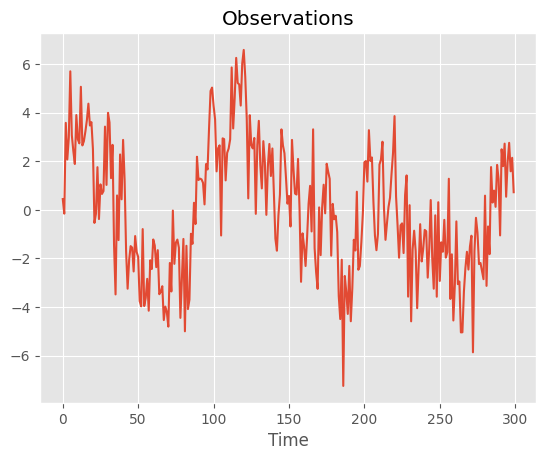

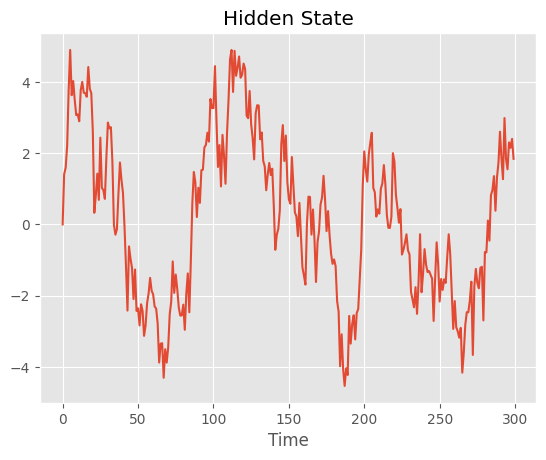

In [2]:
from particles import state_space_models as ssm

'''Below is the model definition, the distribution of the initial state, the markov transition density, and the observation density are given'''

class TestModel(ssm.StateSpaceModel):
    def PX0(self):  # Distribution of X_0
        return dists.Dirac(loc=0.)
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(self.rho * xp, scale=self.sigmaX)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=x, scale=self.sigmaY)
    

my_model = TestModel(rho = 0.9,sigmaX = 0.8,sigmaY = 1.2)  # actual model
true_states, data = my_model.simulate(300)  # we simulate from the model 100 data points

pd.DataFrame(data).to_csv('AR_Test_Observation.csv',index=False)
pd.DataFrame(true_states).to_csv('AR_Test_States.csv',index=False)

plt.style.use('ggplot')
plt.title("Observations")
plt.xlabel('Time')
plt.plot(data)
plt.show()

plt.title("Hidden State")
plt.xlabel('Time')
plt.plot(true_states)
plt.show()

In [3]:
'''Testing inference using the particle filter and checking the likelihood estimates'''

fk_model = ssm.Bootstrap(ssm=my_model, data=data)  # we use the Bootstrap filter
pf = SMC(fk=fk_model, N=100, resampling='systematic',
                   collect=[Moments()], store_history=True)  # the algorithm
pf.run()  # actual computation

means = [m['mean'] for m in pf.summaries.moments]
vars = [m['var'] for m in pf.summaries.moments]



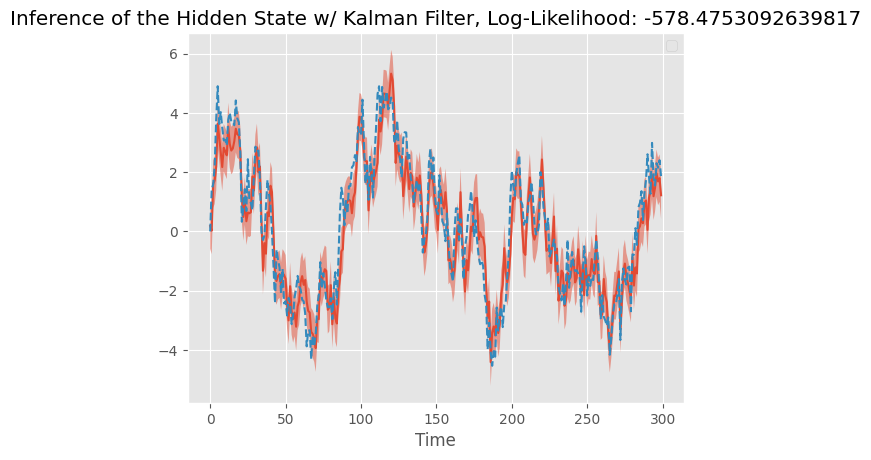

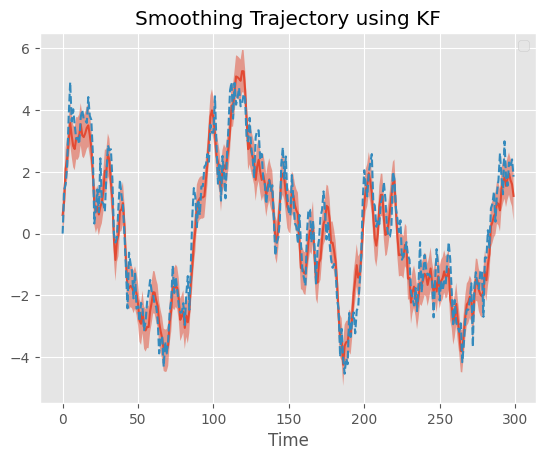

In [4]:
'''Testing inference using the Kalman Filter and checking the analytic likelihood'''
GaussianAR = kalman.LinearGauss(rho=0.9, sigmaX=0.8, sigmaY=1.2, sigma0=1.)

kf = kalman.Kalman(ssm = GaussianAR,data = data)
kf.filter()

mean = np.array([kf.filt[i].mean for i in range(len(data))]).squeeze()
var = np.array([kf.filt[i].cov for i in range(len(data))]).squeeze()

plt.figure()
plt.title(f"Inference of the Hidden State w/ Kalman Filter, Log-Likelihood: {np.sum(kf.logpyt)}")
plt.xlabel('Time')
plt.plot(mean)
plt.fill_between(np.arange(0,len(data)), mean - np.sqrt(var), mean + np.sqrt(var),alpha = 0.5)
plt.plot(true_states,'--')
plt.legend()

###Smoothing KF
kf.smoother()

mean = np.array([kf.smth[i].mean for i in range(len(data))]).squeeze()
var = np.array([kf.smth[i].cov for i in range(len(data))]).squeeze()

plt.figure()
plt.title(f"Smoothing Trajectory using KF")
plt.xlabel('Time')
plt.plot(mean)
plt.fill_between(np.arange(0,len(data)), mean - np.sqrt(var), mean + np.sqrt(var),alpha = 0.5)
plt.plot(true_states,'--')
plt.legend()


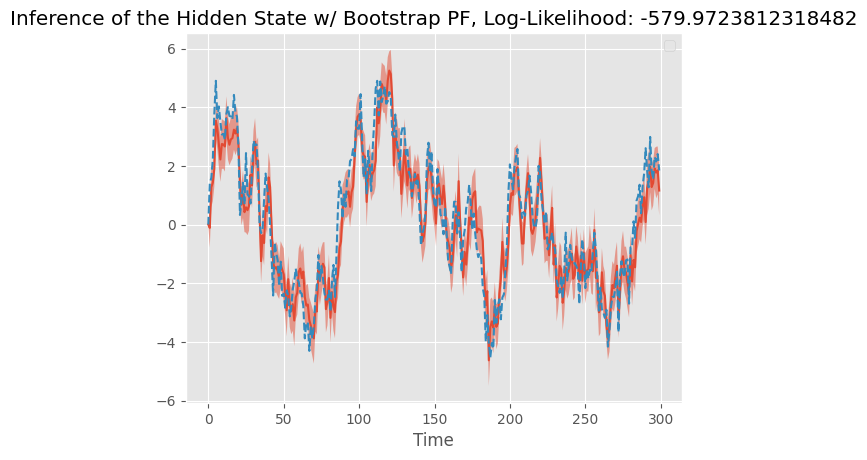

In [5]:
# plot
plt.figure()
plt.title(f"Inference of the Hidden State w/ Bootstrap PF, Log-Likelihood: {pf.logLt}")
plt.xlabel('Time')
plt.plot(means)
plt.fill_between(np.arange(0,len(data)), means - np.sqrt(vars), means + np.sqrt(vars),alpha = 0.5)
plt.plot(true_states,'--')
plt.legend()


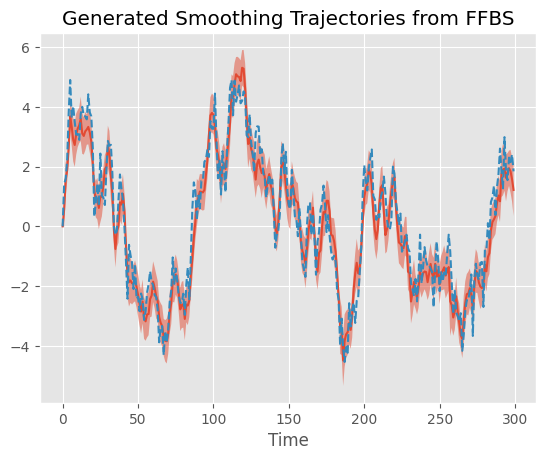

In [6]:
smooth_trajectories = pf.hist.backward_sampling_ON2(100)
plt.title("Generated Smoothing Trajectories from FFBS")
plt.xlabel('Time')
mean = np.mean(smooth_trajectories,axis = 1)
var = np.var(smooth_trajectories,axis = 1)
plt.plot(mean)
plt.plot(true_states,'--')
plt.fill_between(np.arange(0,len(data)), mean - np.sqrt(var), mean + np.sqrt(var),alpha = 0.5)

In [7]:
from particles import mcmc
from particles import datasets as dts  # real datasets available in the package


my_pmmh = mcmc.PMMH(ssm_cls=TestModel, prior=my_prior, data=data, Nx=1000,
                    niter=100_000,adaptive=True,verbose=0)

my_pmmh.run()  # may take several seconds...

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

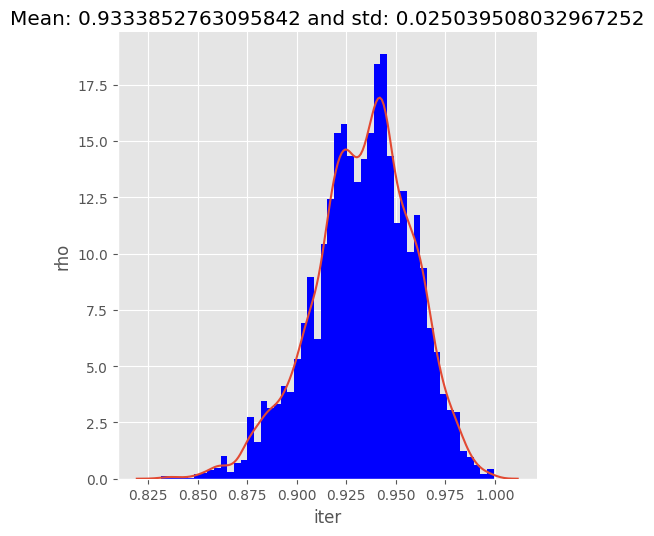

<Figure size 640x480 with 0 Axes>

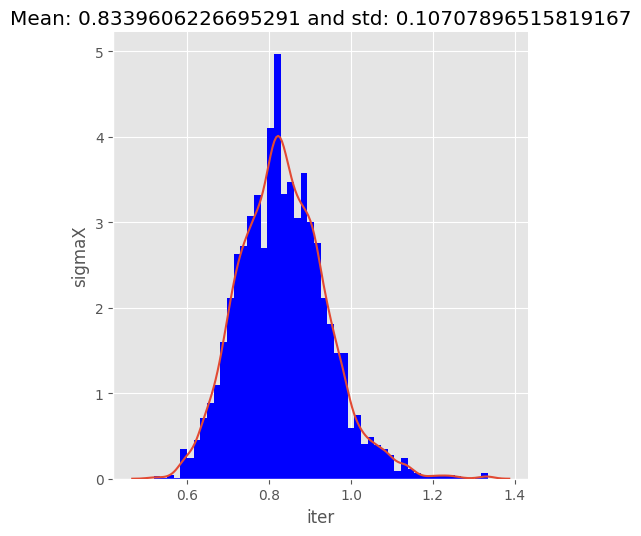

<Figure size 640x480 with 0 Axes>

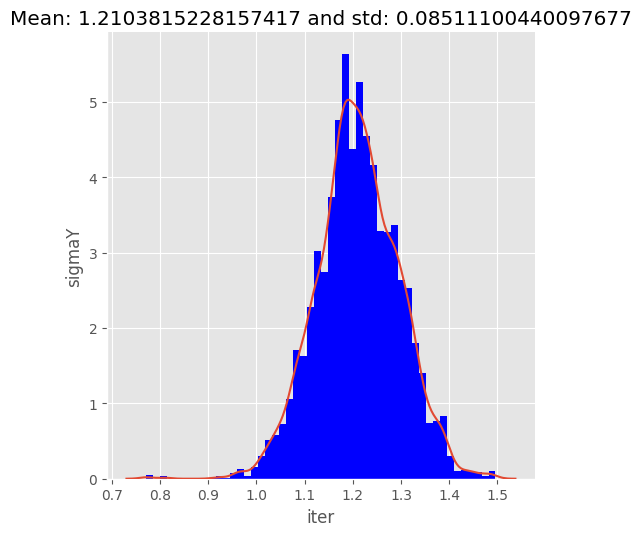

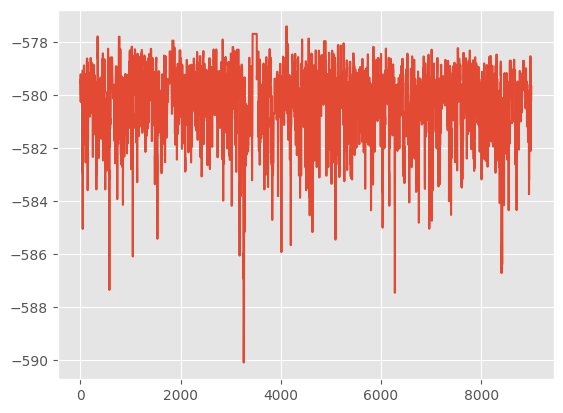

In [ ]:
burn_in = 1000

for p in prior_dict.keys():  # loop over mu, theta, rho
    plt.figure()
    sb.displot(my_pmmh.chain.theta[p][burn_in:], kind = 'kde',zorder = 12)
    plt.title(f"Mean: {np.mean(my_pmmh.chain.theta[p][burn_in:])} and std: {np.std(my_pmmh.chain.theta[p][burn_in:])}")
    plt.hist(my_pmmh.chain.theta[p][burn_in:],density=True,bins = 50,color = 'blue')
    plt.xlabel('iter')
    plt.ylabel(p)
    plt.show()

plt.plot(my_pmmh.chain.lpost[burn_in:])